In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [2]:
df = pd.read_csv('bank-full-Copy1.csv',sep=';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [3]:
df.columns = df.columns.str.lower().str.replace(' ','_')

In [4]:
features = ['age',
'job',
'marital',
'education',
'balance',
'housing',
'contact',
'day',
'month',
'duration',
'campaign',
'pdays',
'previous',
'poutcome',
'y']

df = df[features].copy()

In [5]:
features

['age',
 'job',
 'marital',
 'education',
 'balance',
 'housing',
 'contact',
 'day',
 'month',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'poutcome',
 'y']

In [6]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_full_train.shape, df_train.shape, df_val.shape, df_test.shape

((36168, 15), (27126, 15), (9042, 15), (9043, 15))

In [7]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = (df_train.y == 'yes').values
y_test = (df_test.y == 'yes').values
y_val = (df_val.y=='yes').values

del df_train['y']
del df_val['y']
del df_test['y']

In [8]:
numerical = df.dtypes[df.dtypes != 'object'].index
numerical

Index(['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous'], dtype='object')

In [9]:
from sklearn.metrics import roc_auc_score, roc_curve


In [10]:
for c in numerical:
    auc = roc_auc_score(y_train, df_train[c])
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[c])
    print('%16s, %.3f' % (c,auc))

             age, 0.512
         balance, 0.589
             day, 0.526
        duration, 0.815
        campaign, 0.571
           pdays, 0.590
        previous, 0.599


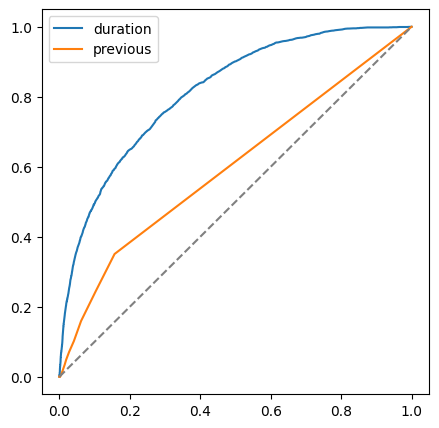

In [11]:
plt.figure(figsize=(5,5))

fpr,tpr,_ = roc_curve(y_train, df_train['duration'])
plt.plot(fpr, tpr, label='duration')

fpr,tpr,_ = roc_curve(y_train, df_train['previous'])
plt.plot(fpr, tpr, label='previous')

plt.plot([0,1], [0,1], color='grey', linestyle='--')

plt.legend()

In [12]:
train_dicts = df_train.to_dict(orient='records')
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

val_dicts = df_val.to_dict(orient='records')
X_val = dv.transform(val_dicts)

y_pred = model.predict_proba(X_val)[:, 1]

In [13]:
roc_auc_score(y_val, y_pred)


np.float64(0.9004159581551736)

In [30]:
def confusion_matrix_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)

    return df_scores

In [32]:
df_scores = confusion_matrix_dataframe(y_val, y_pred)
df_scores[::10]

,threshold,tp,fp,fn,tn
0,0.0,1098,7944,0,0
10,0.1,926,1493,172,6451
20,0.2,712,693,386,7251
30,0.3,566,407,532,7537
40,0.4,462,272,636,7672
50,0.5,373,192,725,7752
60,0.6,290,137,808,7807
70,0.7,225,101,873,7843
80,0.8,148,67,950,7877
90,0.9,76,27,1022,7917


In [33]:
df_scores['p'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['r'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores[::10]

,threshold,tp,fp,fn,tn,p,r
0,0.0,1098,7944,0,0,0.121433,1.000000
10,0.1,926,1493,172,6451,0.382803,0.843352
20,0.2,712,693,386,7251,0.506762,0.648452
30,0.3,566,407,532,7537,0.581706,0.515483
40,0.4,462,272,636,7672,0.629428,0.420765
50,0.5,373,192,725,7752,0.660177,0.339709
60,0.6,290,137,808,7807,0.679157,0.264117
70,0.7,225,101,873,7843,0.690184,0.204918
80,0.8,148,67,950,7877,0.688372,0.134791
90,0.9,76,27,1022,7917,0.737864,0.069217


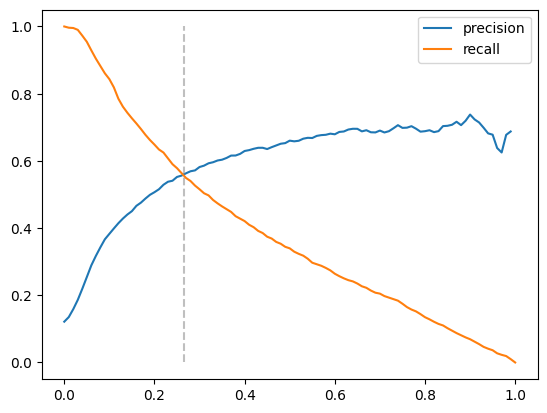

In [34]:
plt.plot(df_scores.threshold, df_scores.p, label='precision')
plt.plot(df_scores.threshold, df_scores.r, label='recall')

plt.vlines(0.265, 0, 1, color='grey', linestyle='--', alpha=0.5)

plt.legend()
plt.show()

In [35]:
df_scores['f1'] = 2* (df_scores.p * df_scores.r)/ (df_scores.p + df_scores.r)
df_scores[::10]

,threshold,tp,fp,fn,tn,p,r,f1
0,0.0,1098,7944,0,0,0.121433,1.000000,0.216568
10,0.1,926,1493,172,6451,0.382803,0.843352,0.526585
20,0.2,712,693,386,7251,0.506762,0.648452,0.568917
30,0.3,566,407,532,7537,0.581706,0.515483,0.546596
40,0.4,462,272,636,7672,0.629428,0.420765,0.504367
50,0.5,373,192,725,7752,0.660177,0.339709,0.448587
60,0.6,290,137,808,7807,0.679157,0.264117,0.380328
70,0.7,225,101,873,7843,0.690184,0.204918,0.316011
80,0.8,148,67,950,7877,0.688372,0.134791,0.225438
90,0.9,76,27,1022,7917,0.737864,0.069217,0.126561


In [36]:
from sklearn.model_selection import KFold


In [37]:
columns = list(df.columns)
columns.remove('y')
columns

['age',
 'job',
 'marital',
 'education',
 'balance',
 'housing',
 'contact',
 'day',
 'month',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'poutcome']

In [38]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[columns].to_dict(orient='records')

    dv = DictVectorizer()
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)

    return dv, model

def predict(df, dv, model):
    dicts = df[columns].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred
scores = []

kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.y.values
    y_val = df_val.y.values

    dv, model = train(df_train, y_train, C=1.0)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print('%.3f +- %.3f' % (np.mean(scores), np.std(scores)))

0.906 +- 0.006


In [39]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for C in [0.000001, 0.001, 1]:
    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.y.values
        y_val = df_val.y.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%4s, %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

C=1e-06, 0.701 +- 0.009
C=0.001, 0.861 +- 0.007
C=   1, 0.906 +- 0.006
